## Checklist

+ Pseudocode, well-written
    + [+] Synthesize paper 
    + [+] Demo flow
    + [] Test on larger raster

+ Get Rainfall Distributions
    + Local areas (circles)
    + Amounts over time 

+ Hydrological Cycle
    + Runoff
    + Precipitation 
    + Infiltration

### Testing
[+] a funcanim of pouring over time, and if things balance out. 
[+] Is mass conserved? 
[ ] Water level on cell/1D slice over time

### Strategies 
+ Blocking Flow (high Walls : what gets flooded in turn?)

### Plotting
[~+] Set rcParams
[+] 3D viz of a DEM
[ ] Flowline of a point using D8, perhaps alternatives
    (then do salmon algo)

### Theoretical Baselines
[+] Flow accumulation matrices
    + "Swimming Upstream" over gradient/slope fields
[+] Maximum flow velocity (mgh -> 1/2 m v^2)

### Upkeep
[+] Save figures
[+] Save data
[+] Refactor code

In [1]:
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

import numpy as np
import sklearn.datasets as ds
from matplotlib import cm
import matplotlib.animation as animation

import richdem as rd
import tqdm 


In [2]:
def init_water(layer, fill = 1):
    # grid is a 1D slice
    # fill is the water column height to fill perimeter with
    water_layer = layer.copy()
   
    water_layer[0,:], water_layer[-1,:] = fill, fill
    water_layer[:,0], water_layer[:, -1] = fill, fill

    return water_layer

directions = {
    0: 1,
    1: 2,
    2: 4,
    3: 8,
    5: 16,
    6: 32, 
    7: 64, 
    8: 128}

def find_direction(window, method  = 'Dinf'):
    # alias: Dinf in literature. Direct flow to lowest neighbor(s)

    # Keys for neighbor positions relative to kernel
    # 0 1 2
    # 3 4 5
    # 6 7 8 
    
    # window has flat array positions
    center = window[4]
    lower_cells = np.where(window < center, window, float('inf'))
    
    # Get indices of downstream cells
    idxs = np.where(lower_cells < float('inf'))
    idxs = list(*idxs)
    
    return np.sum([directions[i] for i in idxs]) if len(idxs) > 0 else 0

def init_directions(layer, method = 'Dinf'):
    # idx for elevation values
    moore_kernel = np.ones((3,3)) 
    
    # TODO: better cval for constant mode
    # maybe repeat? 
    directions = generic_filter(
                    layer,
                    find_direction,
                    footprint = moore_kernel,  
                    mode = 'constant',
                    cval = np.nan)

    # Set border of directions to 0
    directions[0,:] = 0
    directions[:,0] = 0
    directions[-1,:] = 0
    directions[:,-1] = 0
    
    return directions

def calculate_slope(window, d = 1, degrees = True):
    # d is width of a cell

    # 0 1 2 3 [4] 5 6 7 8
    # 0 1 2 3     4 5 6 7

    # if central cell is no_data, return itself
    if window[4] == np.nan or window[4] < 0:
        return window[4]
    
    df_dx = (np.sum(window[[2, 5, 5, 8]])  - np.sum(window[[0, 3, 3, 6]]))/8*d
    df_dy = (np.sum(window[[6, 7, 7, 8]])  - np.sum(window[[0, 1, 1, 2]]))/8*d

    rise_run = np.sqrt(df_dx**2 + df_dy**2)

    if degrees:
        # rise/run -> value in degrees 
        # 57.29578 ~ 180/pi (acceptable precision)
        return np.arctan(rise_run) * 57.29578

    else:
        #return absolute value of rise/run
        return rise_run

def init_slope(dem_layer):
    # Fill out gradients (degrees) for each cell in grid
    # idx for elevation values

    moore_kernel = np.ones((3,3))    
    slopes = generic_filter(
                dem_layer,
                calculate_slope,
                footprint = moore_kernel,  
                mode = 'nearest',
                cval = 0)

    return slopes
    

In [24]:
N = 100

def create_basin(N = 5, layers = 4, seed = 1):
    # Return a toy elevation model
    # layers can be :[DEM, WaterCol, Flooded?, Direction, Slope]
    
    #set seed for reproducibility
    np.random.seed(seed)

    grid = np.zeros((N,N,layers))

    for i in range(N):
        for j in range(N):
            # Use small scale as tally is easier for testing
            grid[i,j,0] -= 50**2*sts.norm.pdf(i*2, loc = N/2, scale = N) + \
                        50**2*sts.norm.pdf(j*2, loc = N/2, scale = N) - 500

    '''
    dem = np.array(
    [
        [10,10,10,10,10],
        [10,8 ,8 ,8 ,10],
        [10,8 ,5,8 ,10],
        [10,8 ,8 ,8 ,10],
        [10,10,10,10,10],
    ]
    )

    grid[...,0] = dem'''

    return init_grid(grid)

def create_pyramid(N = 5):
    pass

def init_grid(grid):
    # Initialise each layer of the grid
    grid = grid.copy()

    grid[...,1] = init_water(grid[...,1])
    grid[...,2] = init_slope(grid[...,0])
    grid[...,3] = init_directions(grid[...,0])
    
    return grid
    
basin = create_basin(N = 100)

In [4]:
basin.shape

(100, 100, 4)

In [28]:
path = './media/beauford.npz'
with np.load(path) as data:
    dem = data['beauford']
    
c = 50
dem = dem[500:500+c, 500:500+c]



In [4]:
def dist(
    layer,
    benchmark = None,

    ax = None,
    title = "",
    bins=20, 
    color='w', 
    edgecolor='k', 
    figsize=(5,3), 
    ):

    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)

    ax.hist(
        layer.flatten(),
        bins = bins,
        color = color, 
        hatch = '///',
        edgecolor = edgecolor)

    ax.set_title(
        title)

    if benchmark:
        ax.axvline(
            benchmark,
            color = 'red',
            label = f''
        )

        ax.plot(
            0,0,',',
            label = f'')
        ax.legend(loc = "upper left")

    adjust_spines(ax, ['bottom'])
    ax.set_xlabel(f'')
    
    plt.tight_layout()
    return ax
        
def adjust_spines(ax, spines, offset = 0):
        for loc, spine in ax.spines.items():
            if loc in spines:
                spine.set_position(('outward', offset))  # outward by offset points
                #spine.set_smart_bounds(True)
            else:
                spine.set_color('none')
        # turn off ticks where there is no spine
        if 'left' in spines:
            ax.yaxis.set_ticks_position('left')
        else:
            # no yaxis ticks
            ax.yaxis.set_ticks([])

        if 'bottom' in spines:
            ax.xaxis.set_ticks_position('bottom')
        else:
            # no xaxis ticks
            ax.xaxis.set_ticks([])


def plot_dem(dem, rotation = 30,  cmap = 'binary', ax = None):
    # A function that plots a DEM (or any 2d array) in 3d

    bins = dem.shape[0]
    dem = dem.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(dem, dem, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz = dem

    cmap = cm.get_cmap(cmap) # discrete colormap
    max_height = np.max(dz)   # max height
    min_height = np.min(dz)    
    # normalize each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    lc = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = rgba, zsort='average')

    # show from side
    ax.view_init(elev=rotation, azim= -90 + rotation)
    # remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    return lc

# A function that plots a DEM heightmap in 4 angles
def orbit_dem(dem, n = 4, cmap = 'Greys_r'):
    # Plot a DEM from different n angles
    # init 3d subplots
    # A figure with a grid of subplots, no margin
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = fig.add_subplot(n, 4, i+1, projection='3d')
        rot = 90 * i/n
        lc = plot_dem(dem, rot, cmap, ax)

    # Make layout compact
    fig.colorbar(lc, ax = ax, shrink = 0.8)
    fig.tight_layout()

    return fig


def plot_water(dem, water, rotation = 30,  cmap = 'binary', ax = None):
    # A function that plots a DEM (or any 2d array) in 3d

    bins = dem.shape[0]
    dem = dem.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(dem, dem, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz = dem

    cmap = cm.get_cmap("Greys") # discrete colormap
    max_height = np.max(dz)   # max height
    min_height = np.min(dz)    
    # normalize each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    lc = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = rgba, alpha = 1, zsort='average')

    # show from side
    ax.view_init(elev=rotation, azim= -90 + rotation)
    # remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


    # Now stack the water map
    bins = water.shape[0]
    water = water.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(water, water, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz1 = water

    cmap = cm.get_cmap("Blues") # discrete colormap
    max_height = np.max(dz1)   # max height
    min_height = np.min(dz1[dz1 > 1e-2])   
    #normalize each z to [0,1], and get their rgb values
    rgba = ["blue" if k > 1e-2 else (1,1,1,0) for k in dz1] 

    # stack over previous 3d barplot
    lc = ax.bar3d(xpos, ypos, dz, dx, dy, dz1, color = rgba, alpha = 1, zsort='average')

    return lc




In [5]:
def get_direction_keys(num):
    # get direction key(s) of lowest neighbor(s)
    binary = np.binary_repr(num, width=8)
    # invert binary convert to list
    binary = list(map(int, binary[::-1]))
    # find all 1s
    indices = np.where(np.array(binary) == 1)

    return list(indices[0]) if len(indices[0]) > 0 else None

def get_direction_idxs(key):
    # unpack ij_dict to displacement indices
    return ij_dict[key][0], ij_dict[key][1]

def make_direction_dict():
        # 3x3 array 0 to 8
    i = np.array([-1,-1,-1, 0, 0, 0, 1, 1, 1])
    j = np.array([-1, 0, 1,-1, 0, 1,-1, 0, 1])

    # stack i and j
    ij = np.stack((i,j), axis = 1)

    # save each row as value in dict
    ij_dict = {k:list(v) for k,v in enumerate(ij)}

    return ij_dict

def generate_flow_acc(dir_grid, n_iters = 10000, max_visits = 5):

    # Take a direction grid and generate flow accumulation grid
    N = dir_grid.shape[0]
    # Init flow accumulation matrix
    flow_acc = np.zeros((N,N))

    ij_dict = make_direction_dict()

    for i in range(n_iters):

        # pick a random cell
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)

        curr_cell = [x,y]
    
        lim = 0
        while lim < max_visits:
            i,j  = curr_cell[0], curr_cell[1]
            direction = int(dir_grid[i,j])
            # Get directions of flow
            dir_keys = get_direction_keys(direction)

            if dir_keys:
                # performance: choose a neighbor to flow to first
                key_idx = np.random.choice(len(dir_keys))
                key = dir_keys[key_idx]
                dx, dy = get_direction_idxs(key)

                downstream_neighbor = [i+dx, j+dy]

                curr_cell = downstream_neighbor
                flow_acc[curr_cell[0], curr_cell[1]] += 1
                lim += 1
            else:
                # reached boundary/outlet, break
                break 

    return flow_acc

In [22]:
basin = create_basin(N = 50, seed = 1)

# cache for modest perf bump
# stack elevation with water columns
N = basin[...,0].shape[0]

area = 1*1
w = np.array([0,0,0,0,0,0,0,0,0])
tau = 1

frames  = []


iter  = 60
tot_mass = np.zeros(iter)
cell_water = np.zeros(iter)
target_cell = [5,5]

#frames.append([plot_water(basin[...,0],basin[...,1])])

for it in tqdm.tqdm(range(iter)):
    water_heights = basin[...,0] + basin[...,1]

    # make a copy of basin
    basin_copy = basin[...,1].copy()

    for i in range(N):
        for j in range(N):
            central_height = water_heights[i,j]
            
            # store downstream neighbors
            v = []
            # calculate height difference between central cell and neighbors
            for dx in range(-1,2):
                for dy in range(-1,2):
                    # if neighbor is in bounds
                    if 0 <= i+dx < N and 0 <= j+dy < N:
                        neighbor_height = water_heights[i+dx,j+dy]
                        # if neighbor is not no_data
                        if neighbor_height > 0:
                            # calculate difference
                            diff = central_height - neighbor_height
                            # exclude self
                            if diff > 0:
                                v.append(((i + dx, j + dy), diff * area))
                
            # sum up differences to find total available volume
            v_tot_avail = np.sum([x[1] for x in v])

            # minimum in v
            try: 
                v_min = min([x[1] for x in v])
            except: 
                v_min = 0.01
            try:
                v_max = max([x[1] for x in v])
            except:
                # possibly np.inf
                v_max = 1e4
            
            # calculate weight for each downstream neighbor
            weights = [(x[0], x[1]/(v_tot_avail + v_min)) for x in v]
            min_weight = v_min/(v_tot_avail + v_min)
            weights.append(((i,j),  min_weight))
    
            w_max = max([x[1] for x in weights])

            # do weights sum to 1
            #assert round(np.array([x[1] for x in weights]).sum()) == 1

            t = 1
            em = 1
            g = 10

            central_depth = basin[i,j,1]
            n = 0.02
            dist = 1 # assume constant to each cell

            manning = 1/n * central_depth**(2/3) * np.sqrt(v_max / dist)
            # maximum permissible velocity
            vm = min(np.sqrt(central_depth*g), manning)

            inter_cell_max = vm * central_depth * t * em

            v_incell = central_depth * area

            ic_vol = min(v_incell, inter_cell_max/w_max, v_min)

            # update water column in neighbors
            for x in weights:
                ii,jj = x[0]
                if i == ii and j == jj:
                    # update water column in central cell
                    basin_copy[ii,jj] -= ic_vol/area
                # update water column in neighbors
                basin_copy[ii,jj] += ic_vol * x[1] / area

    # merge copy into basin
    basin[...,1] = basin_copy

    # For analysis
    #frames.append([plot_water(basin[...,0],basin[...,1])])
    tot_mass[it]  = basin[...,1].sum()
    cell_water[it] = basin[target_cell[0], target_cell[1], 1]


100%|██████████| 60/60 [00:19<00:00,  3.01it/s]


In [7]:
# a test suite that records times for different parameter combinations




basin = create_basin()


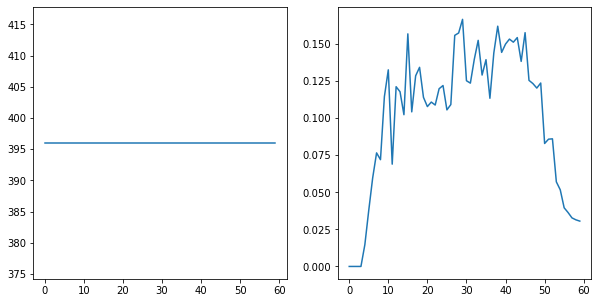

In [23]:
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
plt.plot(tot_mass)

fig.add_subplot(1,2,2)
plt.plot(cell_water)



In [25]:
def make_animation(frames):
    # take a list of figures and animate
    fig = plt.figure()
    ani = animation.ArtistAnimation(fig, frames, interval=5, blit=False, repeat_delay=0)

    return ani
    
ani = make_animation(frames)

ani.save('test2.gif', writer='ffmpeg', fps=30)


MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

In [16]:
frames

[[<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fdc6b7afee0>],

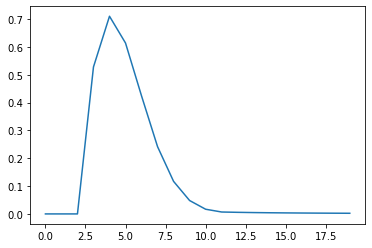

In [ ]:
plt.plot(cell_water)

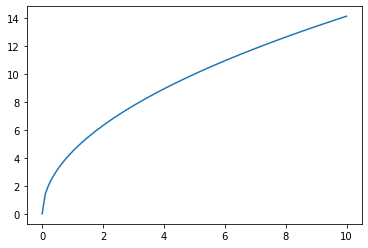

In [ ]:
# Maximum theoretical flow (mgh -> 1/2 mv^2)
def max_flow(d):
    # h = depth of central cell column
    # Energy is conserved
    g = 10
    v = np.sqrt(2*g*d)
    return v

# for different heights, plot max flow
h  = np.linspace(0,10,100)
plt.plot(h, max_flow(h))

# References
+ Working with Rasters
    + https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/
    +https://rasterio.readthedocs.io/en/latest/topics/reproject.html
+ Flow Methods
    + https://richdem.readthedocs.io/en/latest/flow_metrics.html

+ Slope Calculation 
    + Horn paper
    +  https://geol260.academic.wlu.edu/course-notes/digital-terrain-analyses/digital-terrain-analysis-3/
    + Barnes, Richard. 2016. RichDEM: Terrain Analysis Software. http://github.com/r-barnes/richdem


1. Coppola, E., et al. (2007). Cellular automata algorithms for drainage network extraction and rainfall data assimilation.
    + Calculating the direction of flow is hard.
        + Start: minimum energy principle, choose the direction corresponding to the maximum slope (ie lowest cell in neighborhood)
            + However, "singularities due to finite resolution" at pits (where all 8 cells share the same height)  or flat zones (sequences of cells with same elevation)
            + CA2CHYM better than D8
            + smooths DEM (heights)
                x += sum(neighbors)/sum(distances = r)

2. Michele Guidolin et al. (2016). A weighted cellular automata 2D inundation model for rapid flood analysis.
    + The WCA2D model (which this builds on) is a diffusive-like model that **ignores inertia terms and momentum conservation**. It is designed to be as fast as possible for large-scale cachements.

    + The ratios of water transferred from the central cell to thedownstream neighbour cells (intercellular-volume) are calculated using a quick weight-based system
    + The volume of water transferred between the central cell andthe neighbour cells is limited by the Manning's formula and the critical flow equation
    + Both the **adaptive time step** and the velocity are evaluatedwithin a larger updated time step to speed up the simulation.

3. Cirbus, J., Podhoranyi, M. (2013). Cellular Automata for the Flow Simulations on the Earth Surface, Optimization Computation Process
    + The paper suggests that it uses the D8 model for flow direction (pick the **D**irection of the **8** neighbors with the lowest elevation). However, when I replicated Figure 3 in the paper, I found that it was instead doing a "pick the sum of the directions of all lowest neighbors" technique, which I haven't seen in similar papers. 
    + There was a miscalculation in the slope field. I corrected this and tested my calculations against a DEM-manipulation package, and got exactly the same results. 
    + Nonetheless, I have so much concern about the update rules and how they are defined. Each iteration, and each cell, the water in the cell changes by (water in from neighbors [to whom the central cell is the D8 neighbor]) - (water out to D8 neighbor). There is an idea about transfers happening in 'active cells' in the control flow diagram, but there is no mention of what makes a cell active in the rest of the paper. 
    + I don't understand how things are reconciled, in terms of flooded cells. This was vague. 


AttributeError: 'list' object has no attribute 'FuncAnimation'

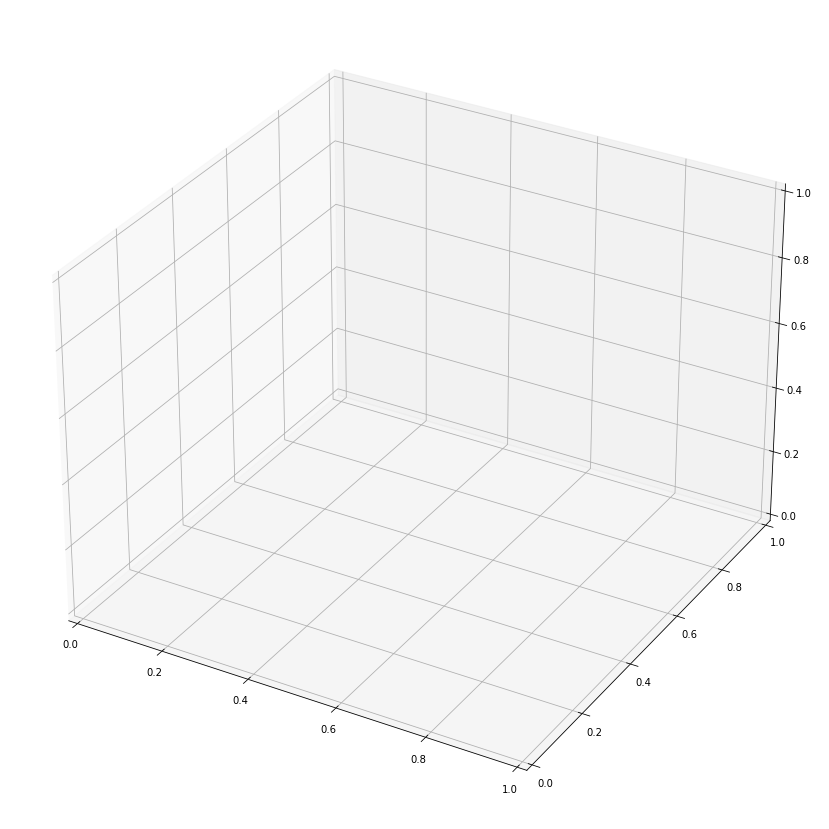

In [ ]:
# Create an animation using FuncAnimation 
def animate_digits_animation(digits, n = 4, cmap = 'Greys_r'):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    def update(i):
        rot = 45
    
        plot_dem(basin[...,1], rot, cmap, ax)

    anim = animation.FuncAnimation(fig, update, frames=n, interval=200)

    return anim

test = animate_digits_animation(basin)
test.save('digits2.gif', writer='imagemagick', fps=10)

In [ ]:
# TODO: cast direction to arrows
down_stream = np.zeros((5,5))
down_stream[0:4,2] = 128

# transform ij indexing to cartesian xy
def ij_to_xy(ij):
    # Take an i,j tuple and return x,y tuple
    i,j = ij[0], ij[0]

    return (j, -i)

def show_directions(dir_grid):
    # quiver plot of directions
    pass

ij_dict = make_direction_dict()

ij_to_xy(get_direction_idxs(7))


def quiver_directions(dir_grid):
    # iterate through dir_grid
    length = dir_grid.shape[0]
    N = dir_grid.size

    X, Y = np.meshgrid(np.arange(length), np.arange(length))
    U = np.zeros(N)
    V = np.zeros(N)

    for i in range(length):
        for j in range(length):
            cell = int(dir_grid[i,j])
            # get first key
            keys = get_direction_keys(cell)
            if not keys:
                continue

            # get i,j of key
            i, j = get_direction_idxs(keys[0])
            # get arrow direction
            u, v = ij_to_xy((i,j))

            idx = np.ravel_multi_index((i,j), dir_grid.shape)

            U[idx] = u
            V[idx] = v

    plt.quiver(X, Y, U, V, scale = 0.5)

quiver_directions(down_stream)

In [40]:
# DEPRECATED

LAYER_NAMES = {
    0 : "Digital Elevation Model",
    1 : "Water Column Height (m)",
    2 : "FLOODED? (bool)",
    3 : "Direction (int)",
    4 : "Slope (degrees)"
}

def view_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1)
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50, cmap = 'magma')
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

def view_3d_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1, projection = '3d')
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50, cmap = 'magma')
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

def view_slice(grid, slice = None, ax = None):

    # Plot a bar chart of heights
    # Brown: elevation 
    # Blue: water
    if slice == None:
        slice = grid.shape[0]//2

    if ax == None:
        fig, ax = plt.subplots()

    N = grid.shape[0]
    ground    = grid[slice,:,0]
    water_col = grid[slice,:,1]

    # Plot Ground
    # plot a bar chart of heights with wave hatching

    ax.bar(
        x = range(1,N+1), 
        height = ground,
        hatch = '///',
        color = 'brown')

    # Plot water column
    ax.bar(
        x = range(1,N+1),
        height  = water_col,
        bottom  = ground,
        hatch = '~'
    )

    lower = 0.95*(min(ground) + min(water_col))
    upper = 1.05*(max(ground) + max(water_col))
    ax.set_ylim((lower,upper))

    # For anim
    return ax
